# Detection of Gravitational Waves

<img src="https://raw.githubusercontent.com/illinois-mlp/MachineLearningForPhysics/main/img/Project_GravitationalWaves-BBHM.jpg" width=500 align=left></img><br>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import warnings
warnings.filterwarnings('ignore')

## <span style="color:Orange">Overview</span>

Gravitational waves are predicted by Einstein's general theory of relativity in 1916, which posits that gravity warps space and time, causing objects traveling through it to follow a curved path. By analogy to electromagnetism, time variation of the mass quadrupole moment of the source is expected to lead to transverse waves of spatial strain. The existence of GW was first demonstrated in 1974 by the discovery of a binary system composed of a pulsar in orbit around a neutron star by Hulse and Taylor [[1]](https://ui.adsabs.harvard.edu/abs/1975ApJ...195L..51H/abstract). However, direct detections of GW did not arrive until 2016. In that year, The LIGO (The Laser Interferometer Gravitational-Wave Observatory) collaboration reported the first direct detection of GW from a binary black hole system merging to form a single black hole [[2]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102). The observations reported in this paper and futher GW detections wprovide new tests of generay relativity in its strong-field regime, and GW observations have become an important new means to learn about the Universe.

In this project, you will reproduce the results reported in [[2]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102) with LIGO open data. You will analyze a particular GW event GW150914 (the first GW ever detected). 

You will also explore machine learning methods applied to simulated LIGO data for the detection of GWs. 

## <span style="color:Orange">Data Sources</span>

This project is based on the open data from the LIGO Scientific Collaboration. The data is hosted by the Gravitational Wave Open Science Center (GWOSC), formerly known as the LIGO Open Science Center, was created to provide public access to gravitational-wave data products. The collaborations running LIGO, Virgo, GEO600, and KAGRA have all agreed to use GWOSC services as the primary access points for public data products. This collaborative approach benefits users by creating a uniform interface to access data from multiple observatories, and provides cost savings to the various observatories by sharing the tools, services, and human resources.

GWOSC Data Repository: https://gwosc.org/data

You will also used simulated GW challenge data from https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/data to explore ML methods for GW detection. 

## <span style="color:Orange">Questions</span>

### <span style="color:LightGreen">Question 01</span>

 What are gravity waves? How are they generated? How fast do they propogate? What can they tell us about the early universe?

Gravity waves are waves of intensity of gravity that is generatd by masses of binary stars. The waves propogate outword from their sources at the speed of light.
Gravitational waves are produced by a single spinning massive object like a neutron star. Gravitational waves can tell about 








https://en.wikipedia.org/wiki/Gravitational_wave#:~:text=Gravitational%20waves%20are%20waves%20of,at%20the%20speed%20of%20light.
https://www.ligo.caltech.edu/page/gw-sources#:~:text=Continuous%20gravitational%20waves%20are%20expected,the%20gravitational%20waves%20it%20emits.

### <span style="color:LightGreen">Question 02</span>

How are they detected? Describe the LIGO experiment and the three detector sites (). 

## <span style="color:Orange">Filtering a TimeSeries to detect gravitational waves</span>


### <span style="color:Violet">Importing and Setup</span>

You will need to install and import the `gwpy` module for data acquisition and helper functions

Please note, you will have to restart runtime to run your code after pip installing the `gwpy` module.

In [2]:
%pip install --ignore-installed --no-cache-dir gwpy

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ---------------------------------------- 61.0/61.0 kB ? eta 0:00:00
     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ---------------------------------------- 60.6/60.6 kB ? eta 0:00:00
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB ? eta 0:00:00
     ---------------------------------------- 0.0/41.9 kB ? eta -:--:--
     ---------------------------------------- 41.9/41.9 kB ? eta 0:00:00
     ---------------------------------------- 0.0/162.8 kB ? eta -:--:--
     -------------------------------------- 162.8/162.8 kB 9.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 1.4/1.4 MB 29.4 MB/s eta 0:00:00
   ----------------------------------------

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\Aditya\\AppData\\Roaming\\Python\\Python311\\site-packages\\yaml\\_yaml.cp311-win_amd64.pyd'
Check the permissions.



The raw ‘strain’ output of the LIGO detectors is recorded as a `TimeSeries` with contributions from a large number of known and unknown noise sources, as well as possible gravitational wave signals.

In order to uncover a real signal we need to filter out noises that otherwise hide the signal in the data. We can do this by using the `gwpy.signal` module to design a digital filter to cut out low and high frequency noise, as well as notch out fixed frequencies polluted by known artefacts.

First we download the raw LIGO-Hanford (H1) strain data from the GWOSC public archive:

In [3]:
from gwpy.timeseries import TimeSeries
hdata = TimeSeries.fetch_open_data('H1', 1126259446, 1126259478)
ldata = TimeSeries.fetch_open_data('L1', 1126259446, 1126259478)

Next we can design a zero-pole-gain (ZPK) filter to remove the extranious noise.

First we import the `gwpy.signal.filter_design` module and create a bandpass() filter to remove both low and high frequency content

In [4]:
from gwpy.signal import filter_design
bp = filter_design.bandpass(50, 250, hdata.sample_rate)

Now we want to combine the bandpass with a series of `notch()` filters, so we create those for the first three harmonics of the 60 Hz AC mains power:

In [5]:
notches = [filter_design.notch(line, hdata.sample_rate) for
           line in (60, 120, 180)]

and concatenate each of our filters together to create a single ZPK model:

In [6]:
zpk = filter_design.concatenate_zpks(bp, *notches)

Now, we can apply our combined filter to the data, using `filtfilt=True` to filter both backwards and forwards to preserve the correct phase at all frequencies

In [7]:
hfilt = hdata.filter(zpk, filtfilt=True)

Note: The filter_design methods return digital filters by default, so we apply them using TimeSeries.filter. If we had analogue filters (perhaps by passing `analog=True` to the filter design method), the easiest application would be `TimeSeries.zpk`

The filter_design methods return infinite impulse response filters by default, which, when applied, corrupt a small amount of data at the beginning and the end of our original `TimeSeries`. We can discard those data using the `crop()` method (for consistency we apply this to both data series):

In [8]:
hdata = hdata.crop(*hdata.span.contract(1))
hfilt = hfilt.crop(*hfilt.span.contract(1))
ldata = ldata.crop(*ldata.span.contract(1))

Finally, we can `plot()` the original and filtered data, adding some code to prettify the figure:

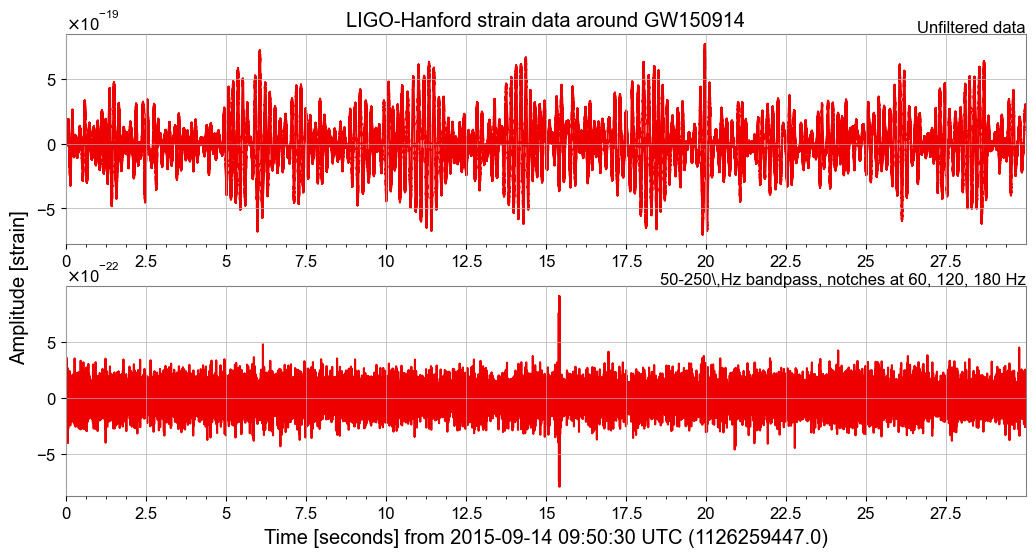

In [9]:
from gwpy.plot import Plot
plot = Plot(hdata, hfilt, figsize=[12, 6], separate=True, sharex=True,
            color='gwpy:ligo-hanford')
ax1, ax2 = plot.axes
ax1.set_title('LIGO-Hanford strain data around GW150914')
ax1.text(1.0, 1.01, 'Unfiltered data', transform=ax1.transAxes, ha='right')
ax1.set_ylabel('Amplitude [strain]', y=-0.2)
ax2.set_ylabel('')
ax2.text(1.0, 1.01, r'50-250\,Hz bandpass, notches at 60, 120, 180 Hz',
         transform=ax2.transAxes, ha='right')
plot.show()

We see now a spike around 16 seconds into the data, so let’s zoom into that time (and prettify):

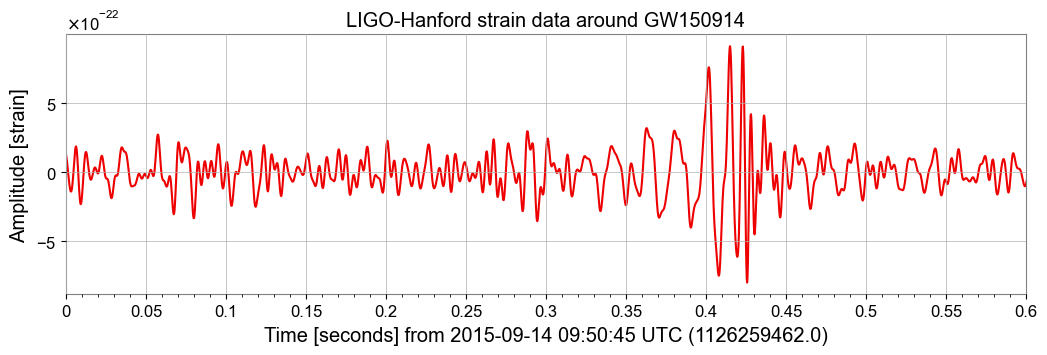

In [10]:
plot = hfilt.plot(color='gwpy:ligo-hanford')
ax = plot.gca()
ax.set_title('LIGO-Hanford strain data around GW150914')
ax.set_ylabel('Amplitude [strain]')
ax.set_xlim(1126259462, 1126259462.6)
ax.set_xscale('seconds', epoch=1126259462)
plot.show()

### <span style="color:LightGreen">Question 03</span>

Congratulations, you have succesfully filtered LIGO data to uncover the first ever directly-detected gravitational wave signal, GW150914! 

But wait, what about LIGO-Livingston (L1)? Your task is to add data from LIGO-Livingston to our figure by following the same procedure. You can load the data with:

`ldata = TimeSeries.fetch_open_data('L1', 1126259446, 1126259478)`

___Hint___: The article announcing the detection told us that the signals were separated by a certain time between the detectors, and that the relative orientation of those detectors means that we need to invert the data from one before comparing them. If you do it right, you should be able to generate a comparison plot resembling the upper-right plot in Figure 1 in [[2]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102).

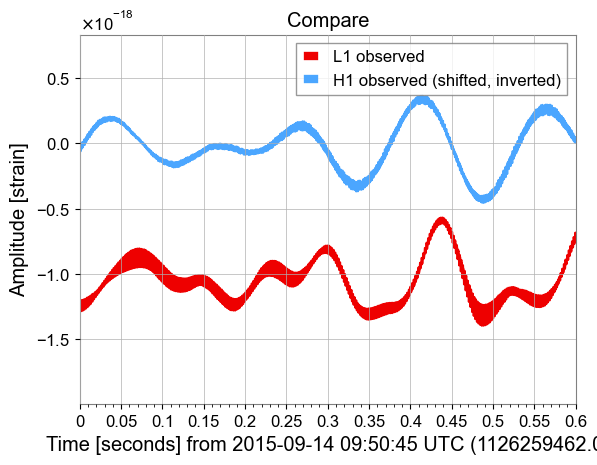

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Plot LIGO-Hanford data
ax.plot(ldata, color='gwpy:ligo-hanford', label='L1 observed')


hdata_inverted = -hdata

# Plot LIGO-Livingston data on the same plot
ax.plot(hdata_inverted, color='gwpy:ligo-livingston', label='H1 observed (shifted, inverted)')

# Set plot properties
ax.set_title('Compare')
ax.set_ylabel('Amplitude [strain]')
ax.set_xlim(1126259462, 1126259462.6)
ax.set_xscale('seconds', epoch=1126259462)

# Add legend
ax.legend()

# Show plot
plt.show()



### <span style="color:Violet">Data in the Frequency Domain</span>

Plotting these data in the Fourier domain gives us an idea of the frequency content of the data. A way to visualize the frequency content of the data is to plot the amplitude spectral density, ASD.

The ASDs are the square root of the power spectral densities (PSDs), which are averages of the square of the fast fourier transforms (FFTs) of the data.

They are an estimate of the "strain-equivalent noise" of the detectors versus frequency, which limit the ability of the detectors to identify GW signals.

They are in units of strain/rt(Hz). So, if you want to know the root-mean-square (rms) strain noise in a frequency band, integrate (sum) the squares of the ASD over that band, then take the square-root.

You will see that the unfiltered LIGO data are dominated by low frequency noise; there is no way to see a signal here, without the signal processing you have done previously.

Text(0.5, 1.0, 'Advanced LIGO strain data near GW150914')

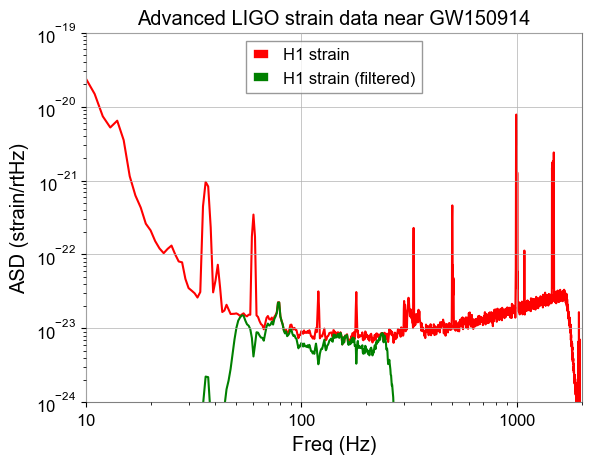

In [12]:
# sampling rate:
fs = 4096

# number of sample for the fast fourier transform:
NFFT = 1*fs
fmin = 10
fmax = 2000
Pxx_H1data, freqs = mlab.psd(hdata, Fs = fs, NFFT = NFFT)
Pxx_H1filt, freqs = mlab.psd(hfilt, Fs = fs, NFFT = NFFT)

# We will use interpolations of the ASDs computed above for whitening:
psd_H1data = interp1d(freqs, Pxx_H1data)
psd_H1filt = interp1d(freqs, Pxx_H1filt)

# plot the ASDs:
plt.figure()
plt.loglog(freqs, np.sqrt(Pxx_H1data),'r',label='H1 strain')
plt.loglog(freqs, np.sqrt(Pxx_H1filt),'g',label='H1 strain (filtered)')
plt.axis([fmin, fmax, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')
plt.title('Advanced LIGO strain data near GW150914')

NOTE that we only plot the data between fmin = 10 Hz and fmax = 2000 Hz.

Below fmin, the data are not properly calibrated. That's OK, because the noise is so high below fmin that LIGO cannot sense gravitational wave strain from astrophysical sources in that band.

The sample rate is fs = 4096 Hz (2^12 Hz), so the data cannot capture frequency content above the Nyquist frequency = fs/2 = 2048 Hz. That's OK, because GW150914 only has detectable frequency content in the range 20 Hz - 300 Hz.

You can see strong spectral lines in the data; they are all of instrumental origin. Some are engineered into the detectors (mirror suspension resonances at ~500 Hz and harmonics, calibration lines, control dither lines, etc) and some (60 Hz and harmonics) are unwanted. We'll return to these, later.

### <span style="color:LightGreen">Question 04</span>

Generate the analogous ASD vs Frequency plot to the one above for the LIGO-Livingston (L1) data and generate a plot that directly compares the H1 and L1 data (analogous to Figure 3 in [[2]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102)).

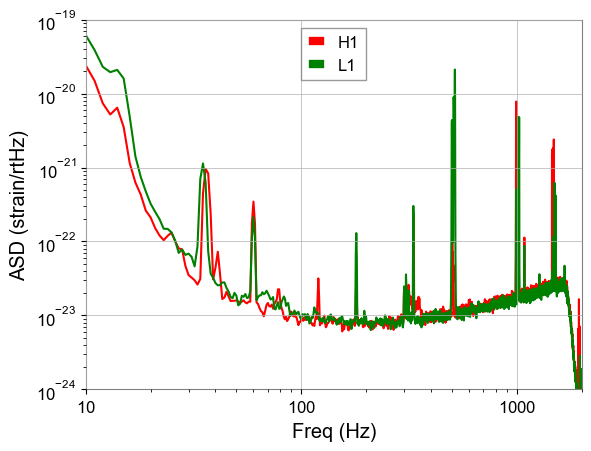

In [13]:
# sampling rate:
fs = 4096

# number of sample for the fast fourier transform:
NFFT = 1*fs
fmin = 10
fmax = 2000
Pxx_H1data, freqs = mlab.psd(hdata, Fs = fs, NFFT = NFFT)
Pxx_L1data, freqs1 = mlab.psd(ldata, Fs = fs, NFFT = NFFT)

# We will use interpolations of the ASDs computed above for whitening:
psd_H1data = interp1d(freqs, Pxx_H1data)
psd_L1data = interp1d(freqs1, Pxx_L1data)

# plot the ASDs:
plt.figure()
plt.loglog(freqs, np.sqrt(Pxx_H1data),'r',label='H1')
plt.loglog(freqs, np.sqrt(Pxx_L1data),'g',label='L1')
plt.axis([fmin, fmax, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')

### <span style="color:Violet">Evolution of the Frequency over Time: The Spectrogram</span>

One of the most useful methods of visualising gravitational-wave data is to use a spectrogram, highlighting the frequency-domain content of some data over a number of time steps. We can calculate a Spectrogram using the spectrogram() method of the TimeSeries over a 2-second stride with a 1-second FFT and # .5-second overlap (50%). Note that `TimeSeries.spectrogram()` returns a Power Spectral Density (PSD) Spectrogram by default, so we use the ** (1/2.) to convert this into a (more familiar) Amplitude Spectral Density.

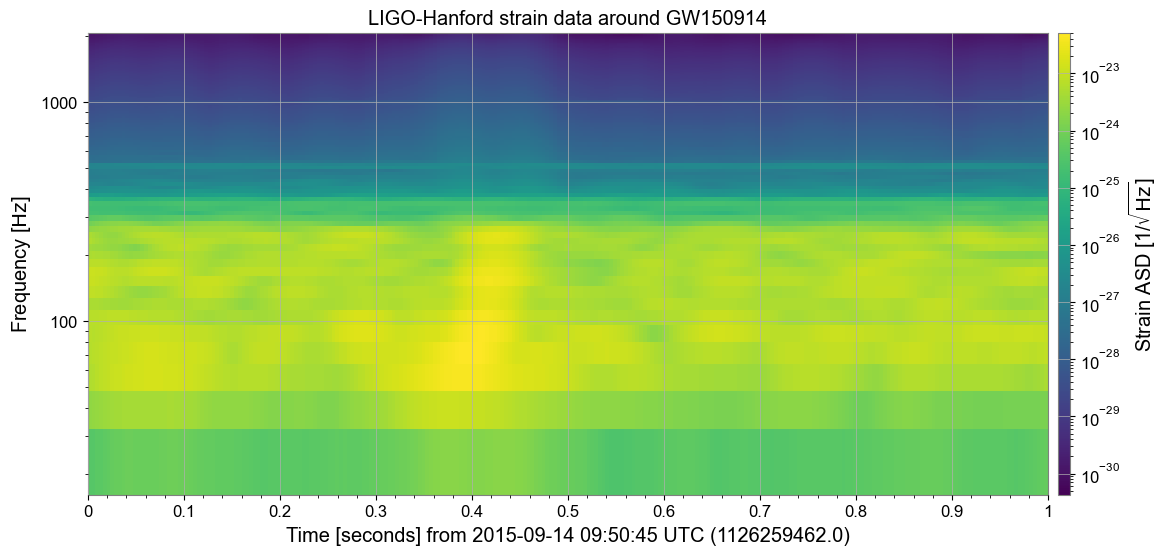

In [14]:
specgram = hfilt.spectrogram2(fftlength=1/16., overlap=15/256.) ** (1/2.)
specgram = specgram.crop_frequencies(20)  # drop everything below highpass

plot = specgram.plot(norm='log', cmap='viridis', yscale='log')
ax = plot.gca()
ax.set_title('LIGO-Hanford strain data around GW150914')
ax.set_xlim(1126259462, 1126259463)
ax.colorbar(label=r'Strain ASD [1/$\sqrt{\mathrm{Hz}}$]')
plot.show()

There is a hint of the famous "chirp" signal (around $t=0.4$ in the plot) representing the spin-down and binary BH merger for the `GW150914` discovery event. With some additional filtering that you will do in the next problem, we can make this much more visible. 

### <span style="color:Violet">Q-transform</span>

One of the most useful tools for filtering and visualising short-duration features in a TimeSeries is the Q-transform. This is regularly used by the Detector Characterization working groups of the LIGO Scientific Collaboration and the Virgo Collaboration to produce high-resolution time-frequency maps of transient noise (glitches) and potential gravitational-wave signals.

This algorithm was used to visualise the first ever gravitational-wave detection `GW150914`, so we can reproduce that result (bottom panel of Figure 1 in n [[2]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102)) here.

In [15]:
!pip install --upgrade gwpy

Defaulting to user installation because normal site-packages is not writeable


### <span style="color:LightGreen">Question 05</span>

With guidance from https://gwpy.github.io/docs/2.1.3/examples/timeseries/qscan, generate and display the Q-filtered spectrogram plots for both the LIGO-Hanford and LIGO-Livingston data. Use the same time and frequency ranges as in [[2]](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102). Specifically, perform the Q-transform for $t=0.2$ seconds around the GW event `GW150914` and set the time-axis limits to be `-0.17 seconds` before the event to `0.03 seconds` after the event. 

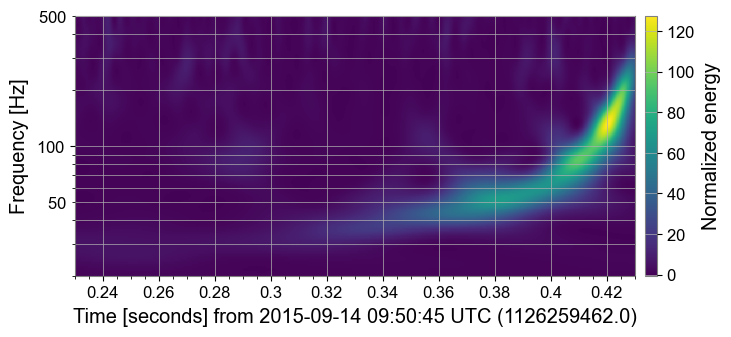

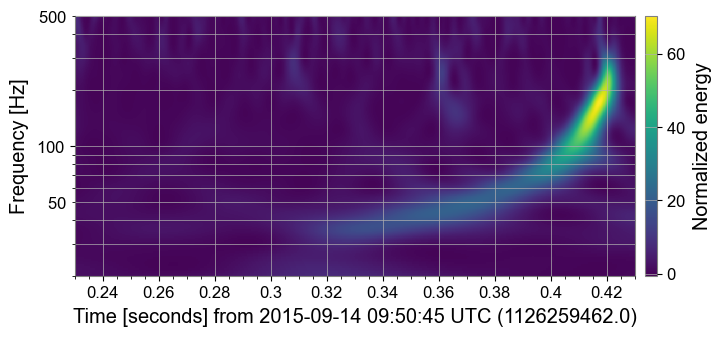

In [16]:
from gwpy.timeseries import TimeSeries

event_time = 1126259462.4  # GW150914
start_time = event_time - 0.17
end_time = event_time + 0.03

hdata = TimeSeries.fetch_open_data('H1', 1126259446, 1126259478)

hq = hdata.q_transform(outseg=(start_time, end_time))

plot = hq.plot(figsize=[8, 4])
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
plot.show()

ldata = TimeSeries.fetch_open_data('L1', 1126259446, 1126259478)

lq = ldata.q_transform(outseg=(start_time, end_time))

plot = lq.plot(figsize=[8, 4])
ax = plot.gca()
ax.set_xscale('seconds')
ax.set_yscale('log')
ax.set_ylim(20, 500)
ax.set_ylabel('Frequency [Hz]')
ax.grid(True, axis='y', which='both')
ax.colorbar(cmap='viridis', label='Normalized energy')
plot.show()


### <span style="color:Violet">Machine Learning Approaches to Gravitational Wave Detection</span>

Given the subtle nature of the GW signals, machine learning methods can be powerful to find gravitational wave signals from binary black hole collisions. Next you will develop and explore one or more ML methods for GW detection using simulated waveforms from the [G2Net Gravitational Wave Detection Challenge](https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/overview).

### <span style="color:LightGreen">Question 06</span>

Develop, train and evaluate an ML model used to detect GW signals from the mergers of binary black holes. Specifically, you'll build a model to analyze simulated GW time-series data from a network of Earth-based detectors.

Some examples could be found [here](https://diposit.ub.edu/dspace/bitstream/2445/201012/1/DANA%20RU%C3%8DZ%20ABEL_7999646.pdf) which use a `Conv1D` network and compare with a pre-trained generative Transformer model. Other challenge participant solutions can be found (here)[https://www.kaggle.com/competitions/g2net-gravitational-wave-detection/code]. You have a lot of freedom in answer this question. A CNN seems like a good start, but feel free to explore ML methods here. Its more important to get one working ML model to classify signal and background waveforms then to thinly "play" with several models. 

You can take inspiration and code from publically-available challenge solutions, but you might cite all sources for full credit!

## <span style="color:Orange">References</span>

* __[<span style="color:Red">1</span>]__ Hulse, R. A. and Taylor, J. H., "Discovery of a pulsar in a binary system" Astrophysical Journal, Vol. 195, p. L51-L53 (1975), https://ui.adsabs.harvard.edu/abs/1975ApJ...195L..51H

* __[<span style="color:Red">2</span>]__ B. P. Abbott et al. (LIGO Scientific Collaboration and Virgo Collaboration), "Observation of Gravitational Waves from a Binary Black Hole Merger", Phys. Rev. Lett. 116, 061102 (2016), https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.116.061102

## <span style="color:Orange">Acknowledgements</span>

* Initial version: Mark Neubauer

© Copyright 2024